# 载入数据集

In [1]:
import cv2
import numpy as np
from tqdm import tqdm

n = 25000
width = 299

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n,), dtype=np.uint8)

for i in tqdm(range(n/2)):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (width, width))
    X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (width, width))

y[n/2:] = 1

100%|██████████| 12500/12500 [00:49<00:00, 251.57it/s]


# 提取特征

In [2]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [3]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [4]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis=-1)

25000/25000 [==============================] - 200s   


# 融合模型

In [5]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 0s - loss: 0.0830 - acc: 0.9754 - val_loss: 0.0352 - val_acc: 0.9960
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0264 - acc: 0.9923 - val_loss: 0.0321 - val_acc: 0.9946
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0224 - acc: 0.9928 - val_loss: 0.0241 - val_acc: 0.9952
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0183 - val_acc: 0.9958
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0176 - acc: 0.9946 - val_loss: 0.0379 - val_acc: 0.9892
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0175 - acc: 0.9942 - val_loss: 0.0210 - val_acc: 0.9948
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0157 - acc: 0.9953 - val_loss: 0.0206 - val_acc: 0.9950
Epoch 8/10
20000/20000 [==============================] - 0s -

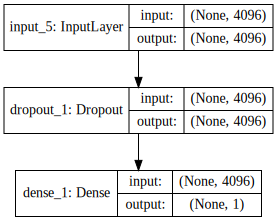

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

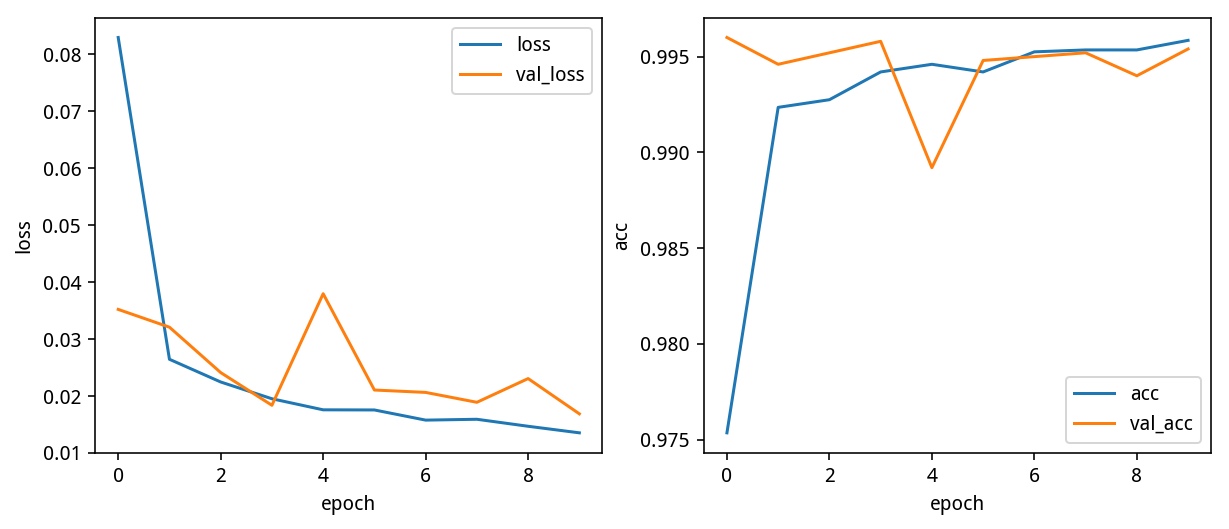

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

# 在测试集上预测并提交到 kaggle 评估

In [8]:
n = 12500
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('test/%d.jpg' % (i+1)), (width, width))

100%|██████████| 12500/12500 [00:24<00:00, 502.62it/s]


In [9]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis=-1)

12500/12500 [==============================] - 100s   


In [10]:
y_pred = model.predict(features_test, batch_size=128)

In [11]:
import pandas as pd

df = pd.read_csv('sample_submission.csv')
df['label'] = y_pred.clip(min=0.005, max=0.995)
df.to_csv('pred.csv', index=None)